# Dataset cross resource analysis

## Common premable

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.abspath(''), '../'))

import peewee as pw
from toyDb.databases import ExperimentDb, ShaderDb
from toyDb.utils.Directory import getToyDbRootDir

import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch

from toyDb.databases.ExperimentDb import (
    Environment,
    ImageOnlyExperiment,
    ImageOnlyResource,
    ImageOnlyShader,
    ImageOnlyTrace
)
from dataset.FragmentPerformanceWithTraceByQueryDataset import FragmentPerformanceWithTraceByQueryDataset

ExperimentDb.init_from_default_db()

## experiments.db & ShaderDb analysis

This analysis is focused on
- Same (w, h) pairs, using `(1024, 768)`
- Same environment
- No augmentation
- Canonical num cycles and num trials
- resource that have different `iTime` and `iFrame` specified

In [2]:
shaderDB = ShaderDb.ShaderDB(os.path.join(getToyDbRootDir(), "shaders"))
shaderDB.scan_local()
shaderDB.load_all()

all_shaders = set(shaderDB.offlineShaders.keys())
imageonly_shaders = shaderDB.filter_attribute(["is_imageonly"])

# all environments available in database
all_environments = Environment.select()

all_resources = ImageOnlyResource.select()

environment_selected = all_environments[0]
print(f"Environment selected: {environment_selected.node} - {environment_selected.cpu} - {environment_selected.gpu} - {environment_selected.gpu_driver}")

w_selected = ExperimentDb.CANONICAL_WIDTH
h_selected = ExperimentDb.CANONICAL_HEIGHT

additional_filters = [
    ImageOnlyExperiment.environment == environment_selected,
    ImageOnlyExperiment.augmentation == 0,
    ImageOnlyExperiment.width == w_selected,
    ImageOnlyExperiment.height == h_selected,
    ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
    ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS,
    ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE
]

additional_filters_might_error = [
    ImageOnlyExperiment.environment == environment_selected,
    ImageOnlyExperiment.augmentation == 0,
    ImageOnlyExperiment.width == w_selected,
    ImageOnlyExperiment.height == h_selected,
    ImageOnlyExperiment.num_cycles == ExperimentDb.CANONICAL_NUM_CYCLES,
    ImageOnlyExperiment.num_trials == ExperimentDb.CANONICAL_NUM_TRIALS
]

# print all possible resources attached from the experiment that we're interested
resource_groups = ImageOnlyResource.select().join(ImageOnlyExperiment).where(*additional_filters).group_by(
    ImageOnlyExperiment.resource
)
resource_group_ids = [grp.id for grp in resource_groups]

print(f"All possible attached resources:")
for idx, res in enumerate(resource_groups):
    unpacked = ExperimentDb.unpackUniformResource(res.uniform_block)
    print(f"- Id {resource_group_ids[idx]}: iResolution={unpacked['iResolution']}, iTime={unpacked['iTime']}, iFrame={unpacked['iFrame']}")

Environment selected: libreliu-GCL-Arch -  Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz - NVIDIA GeForce RTX 3060 - NVIDIA 535.113.01
All possible attached resources:
- Id 1: iResolution=(1024.0, 768.0, 0.0), iTime=1.0, iFrame=1
- Id 4: iResolution=(1024.0, 768.0, 0.0), iTime=2.0, iFrame=120
- Id 5: iResolution=(1024.0, 768.0, 0.0), iTime=3.0, iFrame=180
- Id 6: iResolution=(1024.0, 768.0, 0.0), iTime=7.0, iFrame=420


In [3]:
# 2. Find shader runs that have trace & time readings across all possible (w, h) groups
#    for a given environment

# shaders that have at least 1 non-error measurement and satisfy filter conditions
measurable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id
    ).join(ImageOnlyExperiment).where(
      *additional_filters
    ).distinct()
])

# shaders that have measurements in all (w, h) pairs tested
all_measurable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id,
      ImageOnlyExperiment.resource
    ).join(ImageOnlyExperiment).group_by(
      ImageOnlyShader.shader_id
    ).having(
      pw.fn.COUNT(pw.SQL('*')) == len(resource_group_ids)
    ).where(*additional_filters)
])

In [4]:
def analyzeFailedShaders(failed_shaders: 'set'):
    for failed_shader in failed_shaders:
        print(f"- Analysis for shader {failed_shader} (https://shadertoy.com/view/{failed_shader}):")
        exprQuery = ImageOnlyExperiment.select(
            ImageOnlyShader.shader_id,
            ImageOnlyExperiment.resource,
            ImageOnlyExperiment.width,
            ImageOnlyExperiment.height,
            ImageOnlyExperiment.results,
            ImageOnlyExperiment.trace,
            pw.fn.COUNT(pw.SQL('*'))
        ).join(ImageOnlyShader).switch(ImageOnlyExperiment).join(ImageOnlyResource).group_by(
            ImageOnlyResource.uniform_block
        ).where(
            ImageOnlyShader.shader_id == failed_shader,
            *additional_filters
        )
        # print(exprQuery)
        exprs = [i for i in exprQuery]
        # print(exprs)

        for resInfo in resource_groups:
            found = False
            for expr in exprs:
                if resInfo.id == expr.resource_id:
                    timeResult = np.asarray(json.loads(expr.results))
                    print(
                        f"  - Resource ID={resInfo.id}: \n"
                        f"    - timeMean={np.mean(timeResult)}\n"
                        f"    - timeStd={np.std(timeResult)}\n"
                        f"    - trace={expr.trace}"
                    )
                    found = True
            if not found:
                print(f"  - Resource ID={resInfo.id}: Not found")
        


In [5]:
print(f"Number of shaders in Shadertoy Offline Database: {len(all_shaders)}")
print(f"Number of ImageOnly shaders: {len(imageonly_shaders)}")
print(f"Number of environments: {len(all_environments)}")

print(f"Number of measurable shaders: {len(measurable_shaders)}")
print(f"Number of all measurable shaders: {len(all_measurable_shaders)}")

# Print analysis for each of the shader that failed the group
analyzeFailedShaders(measurable_shaders - all_measurable_shaders)

Number of shaders in Shadertoy Offline Database: 0
Number of ImageOnly shaders: 0
Number of environments: 1
Number of measurable shaders: 13897
Number of all measurable shaders: 13856
- Analysis for shader 7tlyDs (https://shadertoy.com/view/7tlyDs):
  - Resource ID=1: Not found
  - Resource ID=4: 
    - timeMean=0.00132391936
    - timeStd=7.5704170640548924e-06
    - trace=45101
  - Resource ID=5: 
    - timeMean=0.0013310293333333334
    - timeStd=1.0166566204356091e-05
    - trace=64651
  - Resource ID=6: 
    - timeMean=0.0013328247466666667
    - timeStd=8.393596960900895e-06
    - trace=71874
- Analysis for shader ld33RX (https://shadertoy.com/view/ld33RX):
  - Resource ID=1: Not found
  - Resource ID=4: 
    - timeMean=1.709056e-05
    - timeStd=2.6658985560428288e-08
    - trace=50236
  - Resource ID=5: Not found
  - Resource ID=6: Not found
- Analysis for shader ftyyz3 (https://shadertoy.com/view/ftyyz3):
  - Resource ID=1: Not found
  - Resource ID=4: Not found
  - Resource I

In [6]:
measurable_and_traceable_shaders = set([shdr.shader_id for shdr in ImageOnlyShader.select(
      ImageOnlyShader.shader_id
    ).join(ImageOnlyExperiment).where(
      *additional_filters,
      ImageOnlyExperiment.trace.is_null(False)
    ).distinct()
])

# shaders that have measurements in all (w, h) pairs tested
all_measurable_and_traceable_shaders_query = ImageOnlyShader.select(
      ImageOnlyShader.shader_id,
      ImageOnlyExperiment.resource
    ).join(ImageOnlyExperiment).group_by(
      ImageOnlyShader.shader_id
    ).having(
      pw.fn.COUNT(pw.SQL('*')) == len(resource_group_ids)
    ).where(
      *additional_filters,
      ImageOnlyExperiment.trace.is_null(False)
)

all_measurable_and_traceable_shaders = set([
    shdr.shader_id for shdr in all_measurable_and_traceable_shaders_query
])

In [7]:
print(f"Number of measurable and traceable shaders: {len(measurable_and_traceable_shaders)}")
print(f"Number of all measurable and traceable shaders: {len(all_measurable_and_traceable_shaders)}")
print()
print(f"Analysis for those that are all measurable but not (all) traceable")

analyzeFailedShaders(measurable_and_traceable_shaders - all_measurable_and_traceable_shaders)

Number of measurable and traceable shaders: 13896
Number of all measurable and traceable shaders: 13848

Analysis for those that are all measurable but not (all) traceable
- Analysis for shader tlB3R1 (https://shadertoy.com/view/tlB3R1):
  - Resource ID=1: 
    - timeMean=0.06260314794666667
    - timeStd=2.1697946536342137e-05
    - trace=8793
  - Resource ID=4: 
    - timeMean=0.0626156544
    - timeStd=2.4517700331672407e-05
    - trace=53486
  - Resource ID=5: 
    - timeMean=0.06261065386666667
    - timeStd=2.852396374213583e-05
    - trace=None
  - Resource ID=6: 
    - timeMean=0.06262010879999999
    - timeStd=1.830489070715643e-05
    - trace=72356
- Analysis for shader 7tlyDs (https://shadertoy.com/view/7tlyDs):
  - Resource ID=1: Not found
  - Resource ID=4: 
    - timeMean=0.00132391936
    - timeStd=7.5704170640548924e-06
    - trace=45101
  - Resource ID=5: 
    - timeMean=0.0013310293333333334
    - timeStd=1.0166566204356091e-05
    - trace=64651
  - Resource ID=6: 
  

In [8]:
measurable_shaders - measurable_and_traceable_shaders

{'Nd33Dr'}

In [9]:
measurable_and_traceable_shaders - all_measurable_and_traceable_shaders

{'3dlcRj',
 '3lBcWy',
 '3lVSDt',
 '3lXfWj',
 '3slfzs',
 '3stBDf',
 '3tdGRj',
 '4td3Dj',
 '7dlfDn',
 '7tBXDh',
 '7tlyDs',
 'Ds23Wd',
 'DtS3DV',
 'MdlfzS',
 'MljSzd',
 'MtSBDc',
 'NddfWN',
 'NdfXR7',
 'NlXSRX',
 'XdffR2',
 'dlc3Wl',
 'dlfSDM',
 'fl2Sz3',
 'ftyyz3',
 'ld2BDy',
 'ld33RX',
 'ld3cWj',
 'ldXBDM',
 'llVGRc',
 'llfSzH',
 'lsXyWN',
 'lssBRX',
 'msc3W2',
 'sd2cW3',
 'sdSGDm',
 'ssV3zR',
 'stSSWW',
 'tl3Gzr',
 'tlB3R1',
 'tlX3W8',
 'tllyWf',
 'tssfW2',
 'ttGBRR',
 'ttffzS',
 'tttyzB',
 'wdSXzK',
 'ws2GDt',
 'wsfyDs'}

## Time-shift analysis

Analysis the shift of time as time goes.

In [10]:
timeMeasured = np.zeros((len(resource_groups), len(all_measurable_and_traceable_shaders), ExperimentDb.CANONICAL_NUM_TRIALS), dtype=np.double)

# ((w,h), shader_id in string)
exprFilled = set()

# iterate over experiment to fill in the blank
# https://stackoverflow.com/questions/33901178/translating-sql-sub-query-to-peewee-orm

for subgroupIdx, resource_id in enumerate(resource_group_ids):
    query = ImageOnlyExperiment.select().join(ImageOnlyShader).where(
        *additional_filters,
        ImageOnlyExperiment.resource_id == resource_id
    ).join(all_measurable_and_traceable_shaders_query, on=(
        (ImageOnlyShader.shader_id == all_measurable_and_traceable_shaders_query.c.shader_id)
    )).order_by(
        # THIS IS IMPORTANT! ENSURE OUR DATA IS IN ORDER
        ImageOnlyExperiment.shader_shadertoy_id.asc()
    )
    assert(len(query) == len(all_measurable_and_traceable_shaders))

    curIdx = 0
    for expr in query:
        results = np.asarray(json.loads(expr.results), dtype=np.double)
        
        timeMeasured[subgroupIdx, curIdx, :] = results
        curIdx += 1

    assert(curIdx == len(all_measurable_and_traceable_shaders))

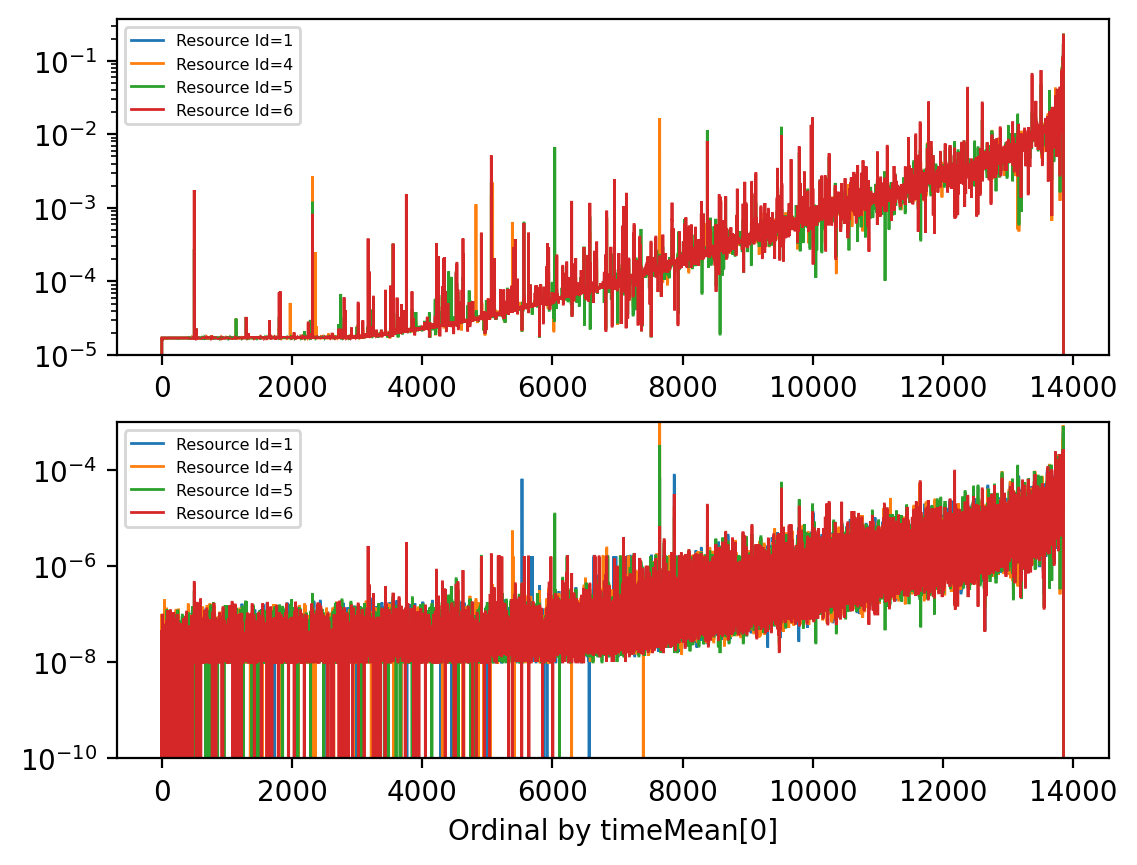

In [11]:
# (wh_groups, shaderIdx)
timeMean = np.mean(timeMeasured, axis=2)
timeStdev = np.std(timeMeasured, axis=2)
min_res_id = min(resource_group_ids)
min_res_id_idx = resource_group_ids.index(min_res_id)

# sort w.r.t. the min w/h array; returns (n_shaders,)
indices = np.argsort(timeMean[min_res_id_idx, :])
timeMeanSorted = timeMean[:, indices]
timeStdevSorted = timeStdev[:, indices]

plt.rcParams['figure.dpi'] = 200
fig, (axMean, axStd) = plt.subplots(2, 1)

axMean.set_yscale('log')
axStd.set_yscale('log')
axStd.set_xlabel('Ordinal by timeMean[0]')
axStd.set_ylim(bottom=1e-10, top=1e-3)

meanHandles = []
stdevHandles = []
for groupIdx in range(len(resource_group_ids)):
    mH = axMean.stairs(timeMeanSorted[groupIdx, :])
    sH = axStd.stairs(timeStdevSorted[groupIdx, :])

    meanHandles.append((mH, f"Resource Id={resource_group_ids[groupIdx]}"))
    stdevHandles.append((sH, f"Resource Id={resource_group_ids[groupIdx]}"))

axMean.legend(handles=[elem[0] for elem in meanHandles],labels=[elem[1] for elem in meanHandles],loc='upper left', fontsize="xx-small")
axStd.legend(handles=[elem[0] for elem in stdevHandles],labels=[elem[1] for elem in stdevHandles],loc='upper left', fontsize="xx-small");

## Trace-shift analysis

Analyse the shift of total trace count for the deviation of the min resource idx ("the base").

In [12]:
traceCountSums = np.zeros((len(resource_groups), len(all_measurable_and_traceable_shaders)), dtype=np.uint64)
traceCountAssociatedShaderIds = []
originalExprIds = []
deviatedExprIds = []

# ((w,h), shader_id in string)
exprFilled = set()

# iterate over experiment to fill in the blank
# https://stackoverflow.com/questions/33901178/translating-sql-sub-query-to-peewee-orm

for subgroupIdx, resource_id in enumerate(resource_group_ids):
    query = ImageOnlyExperiment.select(
        ImageOnlyExperiment.id,
        ImageOnlyExperiment.shader_shadertoy_id,
        ImageOnlyExperiment.trace,
        ImageOnlyTrace.bb_trace_counters
    ).join(ImageOnlyShader).where(
        *additional_filters,
        ImageOnlyExperiment.resource_id == resource_id
    ).join(all_measurable_and_traceable_shaders_query, on=(
        (ImageOnlyShader.shader_id == all_measurable_and_traceable_shaders_query.c.shader_id)
    )).switch(ImageOnlyExperiment).join(ImageOnlyTrace).order_by(
        # THIS IS IMPORTANT! ENSURE OUR DATA IS IN ORDER
        ImageOnlyExperiment.shader_shadertoy_id.asc()
    )
    assert(len(query) == len(all_measurable_and_traceable_shaders))

    curIdx = 0
    for expr in query:
        bbTraceCounters = np.asarray(json.loads(expr.trace.bb_trace_counters), dtype=np.uint64)

        # do some validation
        if subgroupIdx == 0:
            traceCountAssociatedShaderIds.append(expr.shader_shadertoy_id)
        else:
            assert(traceCountAssociatedShaderIds[curIdx] == expr.shader_shadertoy_id)

        traceCountSums[subgroupIdx, curIdx] = np.sum(bbTraceCounters)
        # maintain deviated samples
        if subgroupIdx > 0:
            diff = traceCountSums[subgroupIdx, curIdx] - traceCountSums[0, curIdx] \
                if traceCountSums[0, curIdx] < traceCountSums[subgroupIdx, curIdx] \
                    else traceCountSums[0, curIdx] - traceCountSums[subgroupIdx, curIdx]
            if diff != 0:
                deviatedExprIds.append(expr.id)
        else:
            originalExprIds.append(expr.id)

        curIdx += 1

    assert(curIdx == len(all_measurable_and_traceable_shaders))

print(f"Total: {len(resource_group_ids)} * {len(all_measurable_and_traceable_shaders)} = {len(resource_group_ids) * len(all_measurable_and_traceable_shaders)}")
print(f"Deviated: {len(deviatedExprIds)}")
print(f"Original: {len(originalExprIds)}")

Total: 4 * 13848 = 55392
Deviated: 17825
Original: 13848


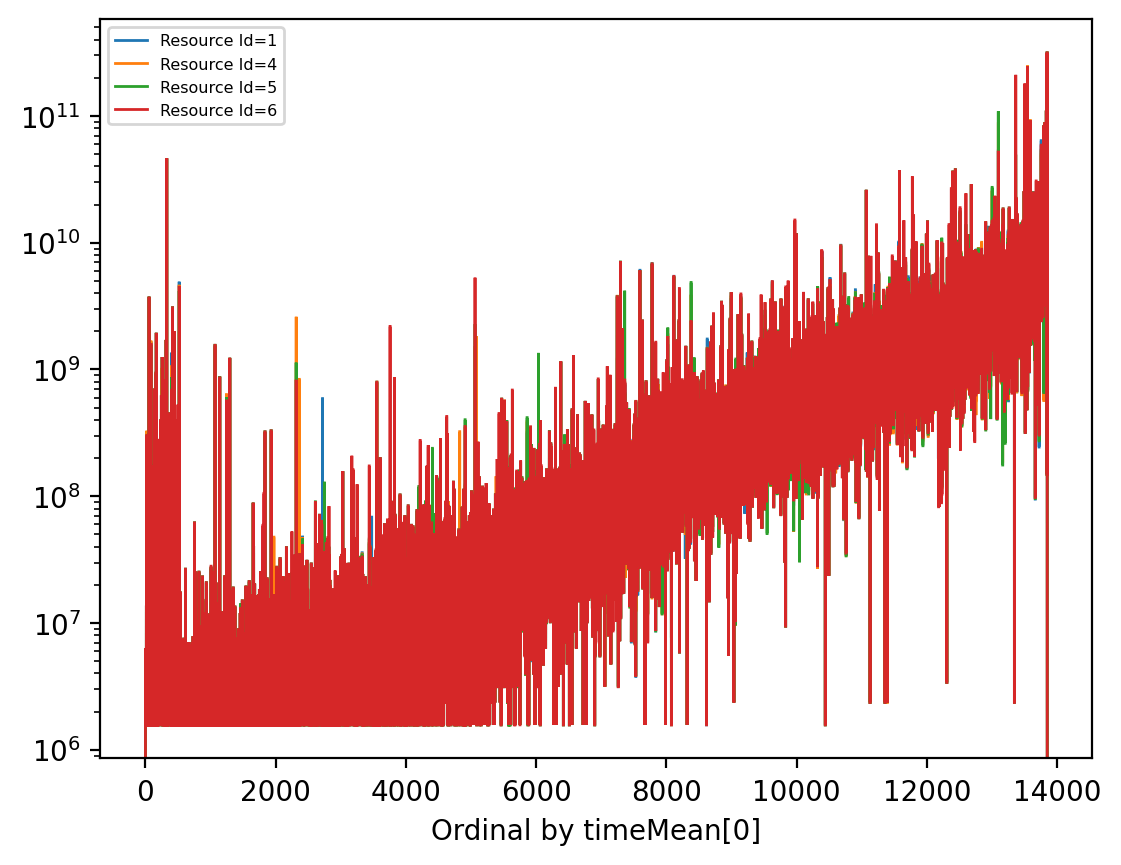

In [13]:
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots()

traceCountSumsSorted = traceCountSums[:, indices]
ax.set_yscale('log')
ax.set_xlabel('Ordinal by timeMean[0]')

handles = []
for groupIdx in range(len(resource_group_ids)):
    H = ax.stairs(traceCountSumsSorted[groupIdx, :])

    handles.append((H, f"Resource Id={resource_group_ids[groupIdx]}"))

ax.legend(handles=[elem[0] for elem in handles],labels=[elem[1] for elem in meanHandles],loc='upper left', fontsize="xx-small")

Show the deviation relative to base experiment.

Text(0, 0.5, '# of experiments')

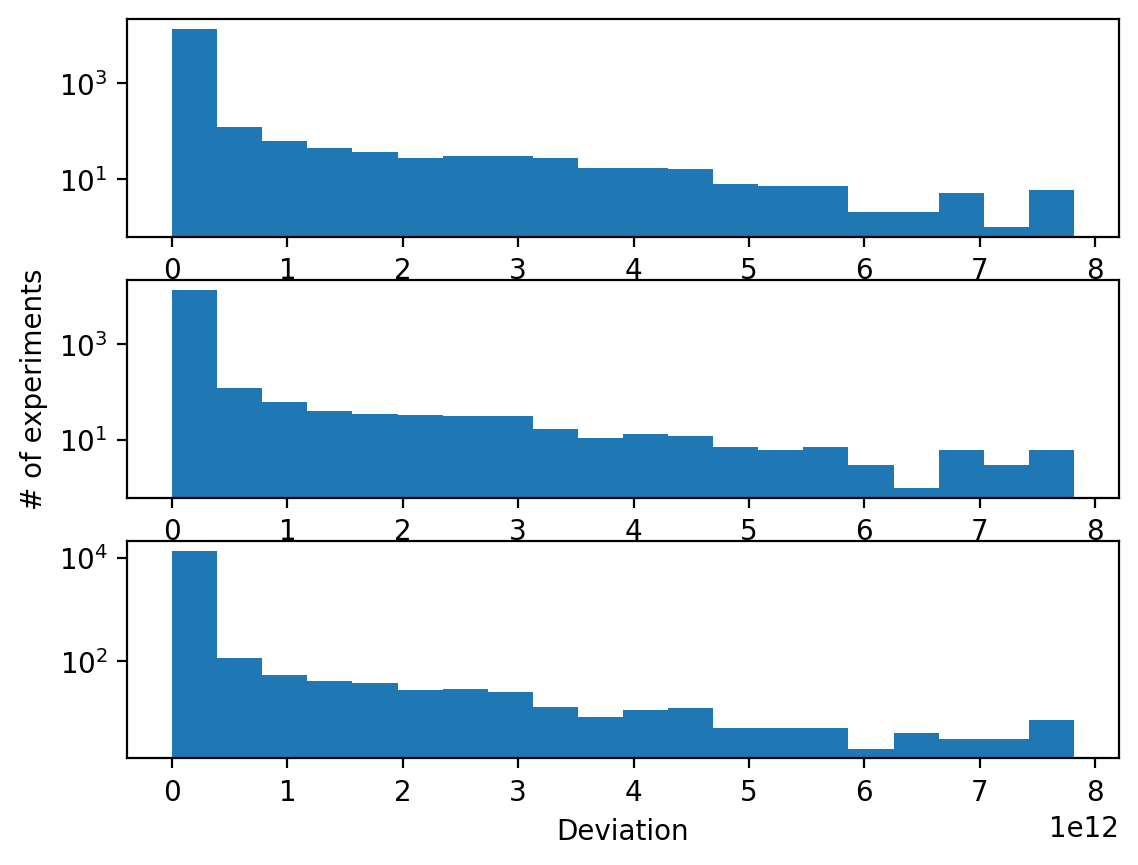

In [14]:
assert(len(resource_groups) >= 2)

traceCountSumDiffs = np.zeros((len(resource_groups) - 1, len(all_measurable_and_traceable_shaders)), dtype=np.double)
for idx in range(len(resource_groups) - 1):
    traceCountSumDiffs[idx, :] = (np.abs(traceCountSums[idx + 1, :] - traceCountSums[0, :]) / traceCountSums[0, :])
    # traceCountSumDiffs[idx, :] = (np.abs(traceCountSums[idx + 1, :] - traceCountSums[0, :]))
    # traceCountSumDiffs[idx, :] = np.min(
    #     np.vstack([traceCountSumDiffs[idx, :], np.ones_like(traceCountSumDiffs[idx, :]) * 10000]), axis=0
    # )

fig, axs = plt.subplots(len(resource_groups) - 1, 1)
for idx in range(len(resource_groups) - 1):
    axs[idx].hist(traceCountSumDiffs[idx], bins=20)    
    axs[idx].set_yscale('log')
    # axs[idx].set_xscale('log')

axs[-1].set_xlabel('Deviation')
axs[-2].set_ylabel('# of experiments')

Filter out the deviated samples, read existing train / test split, and add to train set.

The test set remains unchanged.

In [18]:
from dataset.FragmentPerformanceTracedSnapshotDataset import FragmentPerformanceTracedSnapshotDataset
from misc.Directory import (
  getIntermediateDir
)

origFile = os.path.join(
  getIntermediateDir(),
  "./FragPerfSnapshotTracedDataset4096-3060.dat"
)

origTrainDataset = FragmentPerformanceTracedSnapshotDataset(origFile, 'train')
origTestDataset = FragmentPerformanceTracedSnapshotDataset(origFile, 'test')
totalLen = len(origTrainDataset) + len(origTestDataset)

print(f"Original Train dataset: {len(origTrainDataset)}")
print(f"Original Test dataset: {len(origTestDataset)}")
print(f"Original Total: {totalLen}")

Original Train dataset: 9019
Original Test dataset: 2255
Original Total: 11274


In [21]:
origTrainShaderIds = set()
for sample in origTrainDataset:
    origTrainShaderIds.add(sample["shaderId"])

# only leave those already inside the train shader id group
deviatedAndInsideOriginalTrainDatasetExprIds = []
for deviatedId in deviatedExprIds:
    expr = ImageOnlyExperiment.get_by_id(deviatedId)
    if expr.shader_shadertoy_id in origTrainShaderIds:
        deviatedAndInsideOriginalTrainDatasetExprIds.append(expr.id)
    
# do some reverse lookup
origTrainExprIds = []
for shdrId in origTrainShaderIds:
    res = ImageOnlyExperiment.select().where(
        ImageOnlyExperiment.shader_shadertoy_id == shdrId,
        ImageOnlyExperiment.errors == ExperimentDb.ErrorType.NONE,
        ImageOnlyExperiment.width == w_selected,
        ImageOnlyExperiment.height == h_selected,
        ImageOnlyExperiment.resource == resource_group_ids[0],
        ImageOnlyExperiment.augmentation == ExperimentDb.AugmentationType.NONE
    )
    if len(res) != 1:
        raise RuntimeError(f"Unknown error on {shdrId}, got {len(res)} results instead of 1")
    
    origTrainExprIds.append(res[0].id)

1. New train dataset (unfiltered) uses `origTrainExprIds + deviatedAndInsideOriginalTrainDatasetExprIds`
2. filter the train dataset to accomodate the constraint
3. write the combined train + test dataset

In [22]:
from misc.Directory import (
  getIntermediateDir
)
import misc.TokenizerBuilder
import logging
import hashlib
import pickle

logging.basicConfig(
  level=logging.INFO,
  format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

destFile = os.path.join(
  getIntermediateDir(),
  "./FragPerfSnapshotTracedDataset4096-3060-add3resgroup-train-augmented.dat"
)
MAX_LENGTH = 4096

OVERRIDE_DATASET_SNAPSHOT_FILE = False
DO_SNAPSHOT = True
if os.path.isfile(destFile):
  print(f"You're overriding {destFile} if you run this cell.")
  print(f"Toggle the above to True if needed")

  if OVERRIDE_DATASET_SNAPSHOT_FILE:
    DO_SNAPSHOT = True
  else:
    DO_SNAPSHOT = False

if DO_SNAPSHOT:
  candTrainExprIds = origTrainExprIds + deviatedAndInsideOriginalTrainDatasetExprIds
  tokenizer = misc.TokenizerBuilder.build_tokenizer("HfTracedSpvTokenizer-multiple-entrypoint")
  unfilteredTrainDset = FragmentPerformanceWithTraceByQueryDataset(candTrainExprIds)
  filteredTrainDsetIdx = []

  for idx in tqdm(range(len(unfilteredTrainDset))):
    try:
      encoded = tokenizer(
        spvBinaryRepr=unfilteredTrainDset[idx]["fragSpv"],
        id2TraceIdxMap=unfilteredTrainDset[idx]["bbIdxMap"],
        traceCounters=unfilteredTrainDset[idx]["bbTraceCounters"]
      )
      if len(encoded["input_ids"]) <= MAX_LENGTH:
        filteredTrainDsetIdx.append(idx)

    except RuntimeError as e:
      print(f"dataset idx={idx} (shaderId={unfilteredTrainDset[idx]['shaderID']}) failed to tokenize, reason: {e}")
      
      continue
  
  print(f"FilteredTrainDset: {len(filteredTrainDsetIdx)}, {len(filteredTrainDsetIdx) / len(unfilteredTrainDset) * 100.0}% of original")
  
  outputTrainSamples = [unfilteredTrainDset[idx] for idx in filteredTrainDsetIdx]
  outputTestSamples = [sample for sample in origTestDataset]

  with open(destFile, "wb") as fp:
    pickle.dump({
      "train": outputTrainSamples,
      "test": outputTestSamples
    }, fp)
  
  print(f"Snapshot written to {destFile}, train: {len(outputTrainSamples)}, test: {len(outputTestSamples)}")
  


100%|██████████| 18304/18304 [08:41<00:00, 35.09it/s]


FilteredTrainDset: 18304, 100.0% of original
Snapshot written to c:\Projects\NGPP\vkPredict\misc\.././intermediates\./FragPerfSnapshotTracedDataset4096-3060-add3resgroup-train-augmented.dat, train: 18304, test: 2255


In [23]:
with open(destFile, "rb") as f:
    file_hash = hashlib.md5()
    chunk = f.read(8192)
    while chunk:
        file_hash.update(chunk)
        chunk = f.read(8192)

print(f"Hash for {destFile}:\n- md5sum: {file_hash.hexdigest()}")

Hash for c:\Projects\NGPP\vkPredict\misc\.././intermediates\./FragPerfSnapshotTracedDataset4096-3060-add3resgroup-train-augmented.dat:
- md5sum: 68370cec2c816e0e435d01de9b1dd44d


Check this

Note: the current way of sample generation is rather complicated and involves lots of hand-tuning.

The next steps are to combine augmented samples, implement random sampling and other tricks to do things in a autonomous way.